次は、金融市場でありがちな戦略に基づいて売買して、その成績に応じて戦略をまねさせる、バージョンを作りたい

### 前提条件

・対数正規分布に従うような企業の規模の変動

・企業規模に比例した「均衡」株価

・採用する戦略の種類は、同時に一種類のみ

・採用する戦略内で、パラメータ調整。パラメータは独自に振動しつつ、収益率の高いエージェントの真似をする傾向も加える

・預金×レバレッジが、買うための資金源

・いずれの戦略でも、ポートフォリオ配分割合目標を持つ


### 戦略（案）

・ファンダメンタルズに応じて売買する。長期的戦略。

・テクニカル分析に応じて売買する。短期的戦略。

・テクニカル分析に応じて売買する。長期的戦略。


In [5]:
using StatsPlots
using Random
using Statistics

In [6]:
mutable struct Agent
    strategy::String
    money::Float64
    sharesQuantity  #   株式保有部数リスト
    sharesRetainedLine  #   株式保有金額のリスト
    total_assets_log    #   資産総額の履歴
    params  #   パラメータのリスト  
    #   ファンダメンタルズ戦略をとる場合 [ポートフォリオのうち預金の割合, 企業評価/時価総額　の、買いの閾値になる倍率, 企業価値/時価総額　の、売りの閾値になる倍率, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    #   インデックス戦略をとる場合      [ポートフォリオのうち預金の割合, 1期のタイムスケール, α5, α4, α3, α2, α1, α0, β1, β2, γ, ポートフォリオ分散度合い(1以上。大きい値の時ほど分散させる)]
    fundamentals    #   企業評価のリスト    ファンダメンタルズ戦略をとる場合しか使わないが、更新はインデックス戦略をとるときでも続ける
    portfolio_target#   ポートフォリオ配分目標。[預金,株式]
    performance::Float64    #   運用成績
end
mutable struct Firm
    stockPrice::Float64     #   株価
    stockQuantity::Float64  #   株式発行部数
    stockPriceLog   #   価格の記録
    stockQuantityLog    #   発行部数の記録
    marketCapitalization::Float64   #   時価総額
    hiddenCorporateValue::Float64   #   企業規模
    buy_offers  #   買い注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
    sell_offers #   売り注文 [(価格(float), 量(float), (エージェントインデックス(integer)),,,,,]
end
function update_hiddenCorporateValue(firms)
    σ_r, σ, μ = 1.0, 10.0, log(100.0)
    σ_p = sqrt(σ^2 + σ_r^2)
    for firm in firms
        f = firm.hiddenCorporateValue
        firm.hiddenCorporateValue = exp((log(f) + σ_r*randn())*σ/σ_p + μ*(1 - σ/σ_p))
    end
end
function update_estimate_corporateValue(agents, firms)
    for agent in agents
        for (i, estimated_value) in enumerate(agent.fundamentals)
            agent.fundamentals[i] = (0.02*firms[i].hiddenCorporateValue + 0.98*estimated_value) * exp(0.01*randn())
        end
    end
end
function update_portfolio_target(agents)
    for agent in agents
        agent.portfolio_target[1] = agent.total_assets_log[end] * agent.params[1]
        agent.portfolio_target[2] = agent.total_assets_log[end] * (1 - agent.params[1])
    end
end
function cal_total_asset(agents)
    for agent in agents
        push!(agent.total_assets_log, sum(agent.sharesRetainedLine) + agent.money)
    end
end
function cal_sharesRetainedLine(agents, firms)
    for agent in agents
        for i = 1:size(agent.sharesQuantity)[1]
            agent.sharesRetainedLine[i] = firms[i].stockPrice*agent.sharesQuantity[i]
        end
    end
end
function fundamentals_trade_offer(agent, firms, j)
    buy, sell = [], []
    marketCap, estimated_value, α, β = 0.0, 0.0, 0.0, 0.0
    for (i, firm) in enumerate(firms)
        marketCap = firm.marketCapitalization
        α, β = agent.params[2], agent.params[3]
        estimated_value = agent.fundamentals[i]
        if α*estimated_value > marketCap
            push!(buy, (α - marketCap/estimated_value, i))  #   α - marketCap/estimated_value が大きいほど買いたい
        elseif β*estimated_value < marketCap
            push!(sell, (marketCap/estimated_value - β, i)) #   marketCap/estimated_value - β が大きいほど売りたい
        end
        firm.buy_offers, firm.sell_offers = [], []
    end
    sort!(buy)
    sort!(sell)
    going_to_sell_price, going_to_buy_price = 0.0, 0.0
    while size(sell)[1] > 0
        x, i = pop!(sell)
        marketCap = firms[i].marketCapitalization
        stockQuantity = firms[i].stockQuantity
        quantity = agent.sharesQuantity[i]
        price = (estimated_value + marketCap)/(2*stockQuantity)
        push!(firms[i].sell_offers, (price, quantity, j))
        going_to_sell_price += price * quantity
    end
    flug = true
    lst = []
    while agent.money + going_to_sell_price < agent.portfolio_target[1]
        if flug
            flug = false
            for (i, q) in enumerate(agent.sharesQuantity)
                if q > 0
                    push!(lst, (i,q))
                end
            end
            shuffle(lst)
        end
        i, quantity = pop!(lst)
        price = firms[i].stockPrice
        push!(firms[i].sell_offers, (price, quantity, j))
        going_to_sell_price += price * quantity
        if size(lst)[1] == 0
            break
        end
    end
    while agent.money + going_to_sell_price - going_to_buy_price > agent.portfolio_target[1] && size(buy)[1] > 0
        x, i = pop!(buy)
        marketCap = firms[i].marketCapitalization
        stockQuantity = firms[i].stockQuantity
        price = (estimated_value + marketCap)/(2*stockQuantity)
        quantity = 1/agent.params[end]*agent.money/price
        push!(firms[i].buy_offers, (price, quantity, j))
        going_to_buy_price += price * quantity
    end
end
function index_trade_offer(agent, firms, j)
    span = agent.params[2]
    if size(firms[1].stockPriceLog)[1] < span*6
        return nothing
    end
    α5, α4, α3, α2, α1 = agent.params[3:7]    #   平均0標準偏差が1の条件を追加する
    α0 = agent.params[8]
    β1, β2 = agent.params[9:10]                #   β1<β2 の条件を追加する
    sell, buy = [], []
    for (i, firm) in enumerate(firms)
        x1, x2, x3, x4, x5, x6 = firm.stockPriceLog[end-5:end]
        p = sum([α0 + α1*(x2-x1)/x1, α2*(x3-x2)/x2, α3*(x4-x3)/x3, α4*(x5-x4)/x4, α5*(x6-x5)/x5])
        if p < β1
            push!(sell, (-p,i))
        elseif p > β2
            push!(buy, (p,i))
        end
    end
    sort!(buy)
    sort!(sell)
    going_to_buy_price, going_to_sell_price = 0, 0
    γ = agent.params[11]    #   総資産に占める目標取引量の割合
    γ2 = (1 - γ/2)*agent.total_assets_log[end]
    while γ2 > going_to_buy_price && size(buy)[1] > 0
        p, i = pop!(buy)
        price = (1+p)*firms[i].stockPrice
        quantity = 1/agent.params[end]*agent.money/price
        going_to_buy_price += price*quantity
        if going_to_buy_price > agent.money
            break
        end
        push!(firms[i].buy_offers, (price, quantity, j))
    end
    while agent.money + going_to_sell_price - going_to_buy_price < agent.portfolio_target[1] && size(sell)[1] > 0
        p, i = pop!(sell)
        price = (1-p)*firms[i].stockPrice
        quantity = agent.sharesQuantity[i]
        going_to_buy_price += price*quantity
        push!(firms[i].sell_offers, (price, quantity, j))
    end
end
function trade_offer(agents, firms)
    for (j, agent) in enumerate(agents)
        if agent.strategy == "fundamentals"
            fundamentals_trade_offer(agent, firms, j)
        elseif agent.strategy == "index"
            index_trade_offer(agent, firms, j)
        end
    end
end
function cal_performance(agents)
    for agent in agents
        agent.performance = (agent.total_assets_log[end] - agent.total_assets_log[end-1])/agent.total_assets_log[end-1]
    end
end
function trade_matching(agents, firms)
    for (i, firm) in enumerate(firms)
        buy, sell = firm.buy_offers, firm.sell_offers
        sort!(buy)
        sort!(sell, rev=true)
        selling_p, selling_q, buying_p, buying_q = 0.0, 0.0, 0.0, 0.0
        trading_p = firm.stockPrice
        pb, qb, jb, ps, qs, js = 0.0, 0.0, -1, 0.0, 0.0, -1
        while buying_p >= selling_p
            if size(buy)[1] == 0 || size(sell)[1] == 0
                break
            end
            if buying_q == 0.0
                pb, qb, jb = pop!(buy)
                buying_q = qb
                buying_p = pb
            end
            if selling_q == 0.0
                ps, qs, js = pop!(sell)
                selling_q = qs
                selling_p = ps
            end
            if buying_p < selling_p
                break
            end
            trading_q = min(buying_q, selling_q)
            buying_q -= trading_q
            selling_q -= trading_q
            trading_p = (pb + ps)/2
            agents[jb].sharesQuantity[i] += trading_q
            agents[js].sharesQuantity[i] -= trading_q
            agents[jb].money -= trading_p*trading_q
            agents[js].money += trading_p*trading_q
        end
        firm.stockPrice = trading_p
        push!(firm.stockPriceLog, trading_p)
    end
end
function update_strategy(agents)
    performance_lst = []
    for (j, agent) in enumerate(agents)
        push!(performance_lst, (agent.performance, j))
    end
    sort!(performance_lst)
    A = Int(floor(size(agents)[1]/10))
    for agent in agents
        teacher = rand(1:A)
        if rand() < 0.05
            new_strategy = agents[teacher].strategy
            agent.strategy = new_strategy
            new_params = append!([agent.params[1]], agents[teacher].params[2:end])
            agent.params = new_params
        end
    end
end
function update_params(agents)
    for agent in agents
        agent.params[1] += 0.01*randn()
        agent.params[1] = abs(agent.params[1])
        if agent.params[1] > 1
            agent.params[1] = 1 - agent.params[1] % 1
        end
        agent.params[end] += rand(-1:1)
        if agent.params[end] <= 0
            agent.params[end] = 1
        end
        if agent.strategy == "fundamentals"
            agent.params[2] += 0.01*randn()
            agent.params[3] += 0.01*randn()
            if agent.params[2] < 0
                agent.params[2] = abs(agent.params[2] % 1)
            end
            if agent.params[3] < 0
                agent.params[3] = abs(agent.params[3] % 1)
            end
        elseif agent.strategy == "index"
            if rand() < 0.01
                agent.params[2] += rand(-1:1) #   タイムスケール
                if agent.params[2] <= 0
                    agent.params[2] = 1
                end
            end
            agent.params[3:7] += 0.01*randn(5)
            agent.params[3:7] .-= mean(agent.params[3:7])
            agent.params[3:7] ./= std(agent.params[3:7])
            agent.params[8] += 0.01*randn()
            agent.params[9:10] += 0.01*randn(2)
            if agent.params[9] > agent.params[10]
                agent.params[9], agent.params[10] = agent.params[10], agent.params[9]
            end
            agent.params[11] += 0.01*randn()
            if agent.params[11] < 0
                agent.params[11] = abs(agent.params[11] % 1)
            elseif agent.params[11] > 1
                agent.params[11] = 1 - agent.params[11] % 1
            end
        end
    end
end
function run_one_term(agents, firms)
    update_hiddenCorporateValue(firms)
    update_estimate_corporateValue(agents, firms)
    trade_offer(agents, firms)
    trade_matching(agents, firms)
    cal_sharesRetainedLine(agents, firms)
    cal_total_asset(agents)
    cal_performance(agents)
    update_strategy(agents)
    update_params(agents)
    update_portfolio_target(agents)
end

run_one_term (generic function with 1 method)

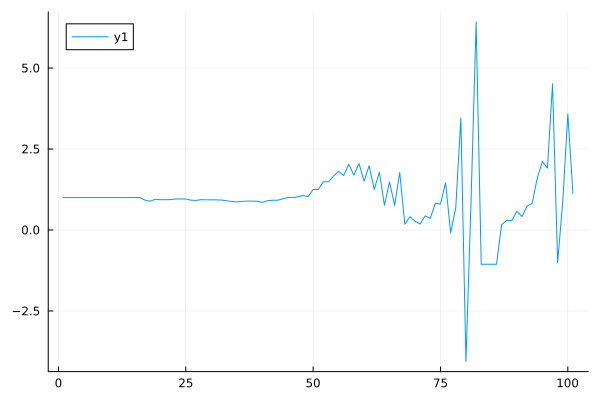

In [7]:
N, M = 10^2, 10 #   エージェント数, 株式会社数
init_money = 100.0*M/N
agents = [
    Agent(
        "index",
        init_money,
        [1.0 for _ = 1:M],
        [1.0 for _ = 1:M],
        [init_money],
        [rand(), 1, randn(), randn(), randn(), randn(), randn(), 0.0, -0.01, 0.01, 0.5, 5],
        [init_money*N/M for _ = 1:M],
        [init_money, init_money],
        0.0,
    ) for j = 1:Int(floor(N/2))
]
for _ = 1:(N - Int(floor(N/2)))
    push!(agents, 
        Agent(
            "fundamentals",
            init_money,
            [1.0 for _ = 1:M],
            [1.0 for _ = 1:M],
            [init_money],
            [rand(), 0.9, 1.1, 5],
            [init_money*N/M for _ = 1:M],
            [init_money, init_money],
            0.0
        )
    )
end
firms = [
    Firm(
        1.0,
        100.0,
        [1.0],
        [100.0],
        100.0,
        100.0,
        [],
        [],
    ) for _ = 1:M
]

for t = 1:100
    run_one_term(agents, firms)
end

plot(firms[1].stockPriceLog)